In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unittest import TestCase

import os

# In order to execute this script, it is necessary to
# set the environment variable engine as "pytorch" before initializing
# simulai
os.environ['engine'] = 'pytorch'

from simulai.templates import HyperTrainTemplate
from simulai.utilities.lorenz_solver import lorenz_solver
from simulai.workflows import ParamHyperOpt
from simulai.regression import DenseNetwork
from simulai.optimization import Optimizer
from simulai.metrics import L2Norm

In [2]:
# Customized class to be used in the hyper-search
class HyperTrainDense(HyperTrainTemplate):

    def __init__(self, trial_config: dict=None, set_type='hard', path_to_model:str =None):

        super().__init__(trial_config=trial_config, set_type=set_type)

        self.path_to_model = path_to_model

    def _set_model(self):

        config = {
                 'layers_units': self.trial_config.get('layers_units'),
                 'activations': self.trial_config.get('activations'),
                 'input_size': self.trial_config.get('input_size'),
                 'output_size': self.trial_config.get('output_size'),
                 'name': self.trial_config.get('name'),
                 }

        self.model = DenseNetwork(**config)

    def _set_optimizer(self):

        optimizer = self.trial_config.get('optimizer')

        optimizer_config = {'lr': self.trial_config.get('lr')}

        # The trial values for the regularization terms are exponents
        self.params = {'lambda_1': 10**self.trial_config.get('lambda_1_exp'),
                       'lambda_2': 10**self.trial_config.get('lambda_2_exp'),
                       'weights': self.trial_config.get('weights')}

        self.loss = self.trial_config.get('loss')
        self.n_epochs = self.trial_config.get('n_epochs')

        self.optimizer = Optimizer(optimizer=optimizer, params=optimizer_config)

    def fit(self, input_train_data=None, target_train_data=None):

        if self.path_to_model:
            self.model.load_state_dict(torch.load(self.path_to_model))
        else:
            pass

        self.optimizer.fit(self.model, input_data=input_train_data, target_data=target_train_data,
                           n_epochs=self.n_epochs, loss=self.loss, params=self.params)


In [3]:
def objective(model, input_validation_data=None, target_validation_data=None):

    approximated_data = model.eval(input_data=input_validation_data)

    l2_norm = L2Norm()

    error = 100 * l2_norm(data=approximated_data, reference_data=target_validation_data, relative_norm=True)

    return error

In [4]:
dt = 0.005
T_max = 50
rho = 28
beta = 8 / 3
beta_str = '8/3'
sigma = 10

Generating datasets.

In [6]:
initial_state = np.array([1, 2, 3])[None, :]
lorenz_data, derivative_lorenz_data = lorenz_solver(rho=rho, dt=dt, T=T_max, sigma=sigma,
                                                    initial_state=initial_state,
                                                    beta=beta, beta_str=beta_str,
                                                    data_path='on_memory')

Iteration 9999

The fraction of data used for training the model.

In [7]:
train_fraction = 0.8
validation_fraction = 0.1

Number of attempts for Optuna.

In [8]:
n_trials = 3

In [41]:
t = time
n_steps = time.shape[0]
nt = int((train_fraction + validation_fraction) * n_steps)
nt_test = n_steps - nt
t_test = t[nt:]

Defining the datasets.

In [9]:
input_data = lorenz_data
output_data = derivative_lorenz_data

Choosing the number of training and testing samples.

In [10]:
n_samples = input_data.shape[0]
train_samples = int(train_fraction*n_samples)
validation_samples = int(validation_fraction*n_samples)

Variables labels.

In [11]:
input_labels = ['x', 'y', 'z']
output_labels = ['x_dot', 'y_dot', 'z_dot']

Time axis.

In [12]:
 time = np.arange(0, n_samples, 1)*dt

Training dataset.

In [13]:
train_input_data = input_data[:train_samples]
train_output_data = output_data[:train_samples]

Validation dataset.

In [22]:
validation_input_data = input_data[train_samples:train_samples + validation_samples]
validation_output_data = output_data[train_samples:train_samples + validation_samples]

Testing dataset

In [23]:
test_input_data = input_data[train_samples + validation_samples:]
test_output_data = output_data[train_samples + validation_samples:]

Some prior parameters choices.

In [24]:
n_inputs = len(input_labels)
n_outputs = len(output_labels)

params_intervals = {'lambda_1_exp': [-5, -3], 'lambda_2_exp': [-5, -3]}
params_suggestions = {'lambda_1_exp': 'float', 'lambda_2_exp': 'float'}

maximum_values = (1 / np.linalg.norm(train_output_data, 2, axis=0)).tolist()

Some parameters left fixed (specifically for this test case).

In [25]:
others_params = {
                    'layers_units': [50, 50, 50],  # Hidden layers
                    'activations': 'elu',
                    'input_size': n_inputs,
                    'output_size': n_outputs,
                    'name': 'lorenz_net',
                    'lr': 1e-3,
                    'n_epochs': int(2e3),
                    'loss': 'wrmse',
                    'optimizer': 'adam',
                    'weights': maximum_values,
                    'batch_size': 100
                }

Base model instance called zero trial.

In [30]:
zero_trial = {'lambda_1_exp': -3, 'lambda_2_exp':-5}
zero_trial.update(others_params)

hyperdense_train = HyperTrainDense(trial_config=zero_trial, set_type='soft')
hyperdense_train.save_model(path='lorenz_weights.pth')

Instantiating the hypersearch engine.

In [31]:
hyper_search = ParamHyperOpt(params_intervals=params_intervals,
                                 params_suggestions=params_suggestions,
                                 name='lorenz_hyper_search',
                                 direction='minimize',
                                 trainer_template=hyperdense_train,
                                 objective_function=objective,
                                 others_params=others_params)

Setting up datasets.

In [32]:
hyper_search.set_data(input_train_data=train_input_data,
                      target_train_data=train_output_data,
                      input_validation_data=validation_input_data,
                      target_validation_data=validation_output_data,
                      input_test_data=test_input_data,
                      target_test_data=test_output_data)

Auxiliary data is not being used.
Auxiliary data is not being used.
Auxiliary data is not being used.


Executing hyper-search itself.

In [33]:
hyper_search.optimize(n_trials=n_trials)

Using and modifying the instance <__main__.HyperTrainDense object at 0x7f707143c1d0> already created.
loss: 0.06896913051605225

[I 2021-12-14 12:13:19,372] Finished trial#0 with value: 3.0160109939386315 with parameters: {'lambda_1_exp': -3.9082872929866337, 'lambda_2_exp': -3.3875243856581565}. Best is trial#0 with value: 3.0160109939386315.


Using and modifying the instance <__main__.HyperTrainDense object at 0x7f707143c1d0> already created.
loss: 0.06365634500980377

[I 2021-12-14 12:14:31,959] Finished trial#1 with value: 3.0214356277133416 with parameters: {'lambda_1_exp': -3.6993965483194815, 'lambda_2_exp': -3.7767489812479047}. Best is trial#0 with value: 3.0160109939386315.


Using and modifying the instance <__main__.HyperTrainDense object at 0x7f707143c1d0> already created.
loss: 0.008454080671072006

[I 2021-12-14 12:15:35,531] Finished trial#2 with value: 1.8572067096707805 with parameters: {'lambda_1_exp': -4.8219524121831165, 'lambda_2_exp': -3.9080510389914442}. Best is trial#2 with value: 1.8572067096707805.


Getting up the best trial.

In [34]:
lorenz_net = hyper_search.retrain_best_trial()

Retraining using the best trial parameters {'lambda_1_exp': -4.8219524121831165, 'lambda_2_exp': -3.9080510389914442, 'layers_units': [50, 50, 50], 'activations': 'elu', 'input_size': 3, 'output_size': 3, 'name': 'lorenz_net', 'lr': 0.001, 'n_epochs': 2000, 'loss': 'wrmse', 'optimizer': 'adam', 'weights': [0.00028053983829971817, 0.00018272034805532072, 0.00015189491754916725], 'batch_size': 100, 'id': 'chosen'}
And the baseline trainer instance <__main__.HyperTrainDense object at 0x7f7071484e50>
loss: 0.018484497442841533

Evaluating error and plotting.

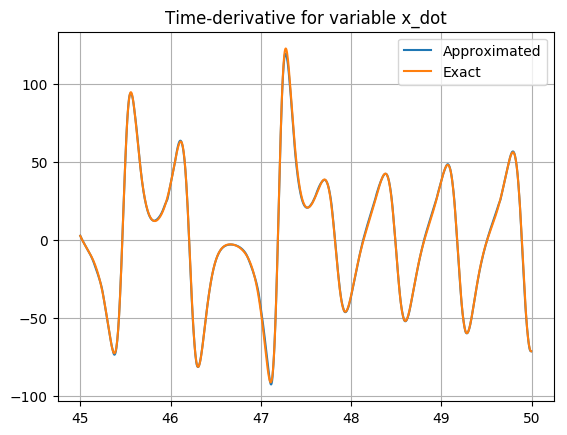

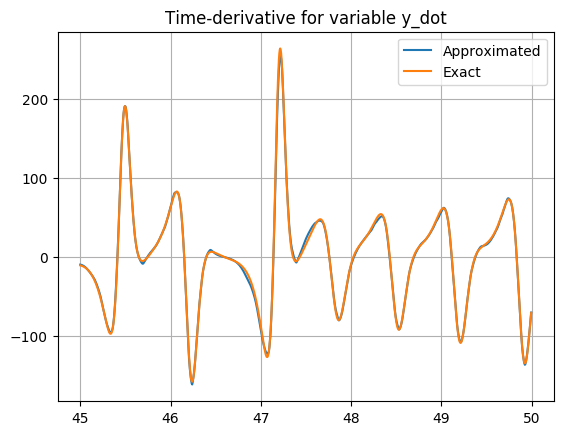

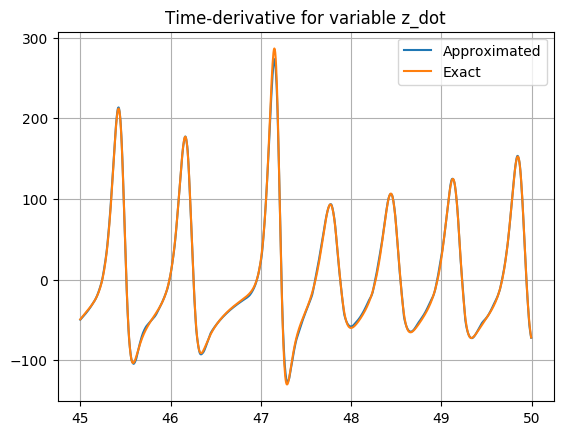

Approximation error for the derivatives: 3.1633789043631397 %


In [42]:
l2_norm = L2Norm()

approximated_data = lorenz_net.eval(input_data=test_input_data)

error = 100*l2_norm(data=approximated_data, reference_data=test_output_data, relative_norm=True)

for ii in range(n_inputs):

    plt.title(f"Time-derivative for variable {output_labels[ii]}")
    plt.plot(t_test, approximated_data[:, ii], label="Approximated")
    plt.plot(t_test, test_output_data[:, ii], label="Exact")
    plt.grid(True)
    plt.legend()
    plt.show()

print(f"Approximation error for the derivatives: {error} %")